# Backtesting y pruebas de estres

Procedimiento fundamental para evaluar si el modelo de riesgo (VaR o CVaR) realmente predice bien las pérdidas extremas. El backtesting consiste en comparar cuántas veces en realidad las pérdidas superan el VaR estimado.

**Procedimiento:**

1. Se estima el VaR ex-ante en cada periodo (Ej: VaR diario
(paramétrico, Histórico, MC)).

2. Se observa el retorno real al final del periodo.

3. Se marca una excepción cuando: $R_t < −VaR_{α,t}$, es decir, si la pérdida real es mayor que la pérdida máxima predicha.

4. Se repite para un horizonte temporal fijo (Ej: 250 días).

**Un ejemplo:**

1. T = 250 días.
2. $α = 0.99$ (99%)
3. No. esperado de excepciones: $(1−α) \times T = (0.01)(250) = 2.5$.
4. No. real de excepciones X.

Si observamos X = 2 excepciones el modelo va bien.

Si observamos X = 5 excepciones el modelo va mal y el VaR está
subestimando el riesgo.

Iniciamos con ....
Importar librerías y datos de **yfinance** para descargar precios ajustados. Horizonte: ago-2019 a ago-2024 para estimación, ago-2024 a ago-2025 para backtest. Lista de Acciones: ["AAPL", "MCD", "HD", "MMM"], índice: S&P500 ['^GSPC'].

In [ ]:
#!pip install --q arch

In [ ]:
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt
import cvxpy as cp  # Convex Optimization - Optimal Portfolio
#from arch import arch_model   # ARCH-GARCH Models
#import statsmodels.api as sm  # Modelos estadisticos y de regresion
from scipy.stats import norm, chi2
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
acciones = ["AAPL", "HD", "MCD", "MMM"]
start = "2019-09-01"
end = "2025-09-25"

# Precios de las acciones
precios = yf.download(acciones, start=start, end=end)["Close"]  # Periodo total de analisis
retornos = np.log(precios / precios.shift(1)).dropna()            # Para retornos dicsretos: data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [ ]:
retornos.head(3)

Ticker,AAPL,HD,MCD,MMM
Date,,,,
2019-09-04,0.016824,0.006445,0.006290,0.008974
2019-09-05,0.019363,0.017688,0.004521,0.025657
2019-09-06,-0.000094,0.012977,0.002457,-0.001767


2. Construcción del portafolio (por ej. usando Markowitz). Usamos media (retorno esperado) y covarianzas de los retornos diarios en el periodo de estimación. Restricción: fully invested (suma de pesos = 1), sin cortos (w>=0). Objetivo: Encontrar portafolio mínimo varianza de la FE de Markowitz.

In [ ]:
# Información de periodo de estimación para crear el portafolio y parametros
start_port = "2019-09-01"     # Fecha inicial - portafolio
end_port   = "2024-09-24"     # Fecha final  - portafolio

retornos_port = retornos.loc[start_port:end_port]  # Informacion de retornos para crear el portafolio
mu = retornos_port.mean().values                   # Retornos esperados diarios
cov = retornos_port.cov().values                   # Matriz de covarianzas

In [ ]:
# Optimizacion
n = len(acciones)
w = cp.Variable(n)  # Se define el vector de incognitas
objectivo = cp.Minimize(cp.quad_form(w, cov))
restricciones = [w >= 0, w.sum()==1]
problema = cp.Problem(objectivo, restricciones)
problema.solve()
wp = w.value

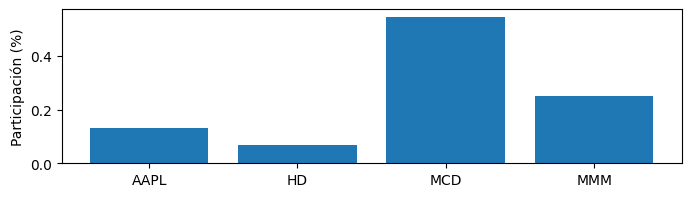

In [ ]:
plt.figure(figsize = (8, 2))
plt.bar(acciones, wp)
plt.ylabel("Participación (%)");

In [ ]:
# Ef: VaR al 99%
rets_port = retornos_port @ wp
alpha = 0.99
var_p = (rets_port.mean() + norm.ppf(1-alpha) * rets_port.std())
var_h = np.percentile(rets_port, 100*(1-alpha))

print('VaR parametrico :', var_p)
print('VaR historico :', var_h)

VaR parametrico : -0.030440941222846244
VaR historico : -0.034056074366985635


**Fallos del modelo**

¿Qué pasa si asumimos un VaR fijo para el periodo analizado? ¿Se debe tomar todo el periodo para evaluar los fallos? ¿Es lo adecuado?

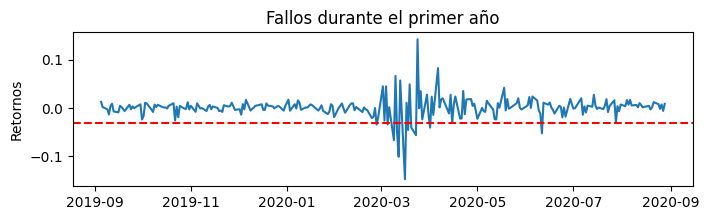

In [ ]:
# Fallos en diferentes periodos
# Primer año
plt.figure(figsize = (8, 2))
plt.plot(rets_port[1:250],label='Retornos historicos')
plt.axhline(var_p, c="r", linestyle="--")
plt.title('Fallos durante el primer año')
plt.ylabel('Retornos');

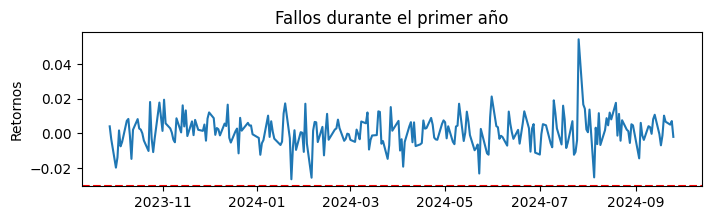

In [ ]:
# Ultimo año
t = len(rets_port)
plt.figure(figsize = (8, 2))
plt.plot(rets_port[t-250:t],label='Retornos historicos')
plt.axhline(var_p, c="r", linestyle="--")
plt.title('Fallos durante el primer año')
plt.ylabel('Retornos');

**Prueba de Backtest**

In [ ]:
#bt_rets_p = port_rets.loc[start_bt:end_bt]
start_bt  = "2024-09-24"     # Fecha inicial backtest
end_bt    = "2025-09-25"
port_test = retornos.loc[start_bt:end_bt] @ wp

In [ ]:
## Funciones del VaR y ES (parametrico e historico)
# -------------------------------
# Función: VaR parametrico
def var_parametrico(rets, alpha):
    return np.mean(rets) + norm.ppf(1-alpha) * np.std(rets)
# -------------------------------
# Función: ES parametrico
def es_parametrico(rets, alpha):
    return np.mean(rets) - np.std(rets) * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
# -------------------------------
# Función: VaR historico
def var_historico(rets, alpha):
    return np.percentile(rets, 100*(1-alpha))
# -------------------------------
# Función: ES historico
def es_historico(rets, alpha):
    var = np.percentile(rets, 100*(1-alpha))
    return rets[rets < var].mean()

In [ ]:
es_p = es_parametrico(rets_port, alpha)
es_h = es_historico(rets_port, alpha)
print('ES parametrico :', es_p)
print('ES historico :', es_h)

In [ ]:
# Calculos para el ultimo año
alpha = 0.99

In [ ]:
port_all = retornos @ wp
t_in = len(rets_port)
t_test = len(port_test)
t_all = len(port_all)
t_in, t_all, t_test

var_backtest_h = []
var_backtest_p = []
es_backtest_h = []
es_backtest_p = []
for i in range(t_in, t_all):
  rets_port_t = port_all[i-250:i]
  # Modelo parametrico
  var_backtest_p.append(var_parametrico(rets_port_t.values, alpha))
  es_backtest_p.append(es_parametrico(rets_port_t.values, alpha))
  # Modelo parametrico
  var_backtest_h.append(var_historico(rets_port_t.values, alpha))
  es_backtest_h.append(es_historico(rets_port_t.values, alpha))

In [ ]:
# Modelo parametrico
plt.figure(figsize = (8, 3))
plt.plot(var_backtest_p,label='VaR paramétrico')
plt.plot(es_backtest_p,label='ES paramétrico')
plt.plot(port_test.values,color="k")
plt.title('Backtest durante el periodo fuera de muestra')
plt.ylabel('Retornos');
plt.legend();

In [ ]:
# Modelo historico
plt.figure(figsize = (8, 3))
plt.plot(var_backtest_h,label='VaR histórico')
plt.plot(es_backtest_h,label='ES histórico')
plt.plot(port_test.values,color="k")
plt.title('Backtest durante el periodo fuera de muestra')
plt.ylabel('Retornos');
plt.legend();

## **¿Cuál es el número de fallos (o de excepciones) adecuado o qué no se debe superar para tener un buen modelo de estimación del VaR?**

## Basilea

El Comité de Basilea (1996) especificó una metodología denominado “semáforo” para realizar pruebas de backtesting de las medidas de VaR. Los bancos deben realizar u backtesting de sus resultados de VaR del 99% a un día comparándolos con sus resultados observados y, con ello, evaluar el desempeño de su modelo. Bajo esta metodología, los fallos del VaR se clasifican en una de las tres zonas de color:

El procedimiento de Basilea no se basa en ninguna prueba estadística. Las tres zonas se justificaron como razonables según lo que el comité consideró en su momento.

In [ ]:
# @title
fallos = [
    {"Rango Fallos": "0 – 4", "Zona": "Verde", "Acción": "Modelo aceptable (no ajustes)", "Multiplicador": 3},
    {"Rango Fallos": "5 – 9", "Zona": "Amarillo", "Acción": "Revisión del modelo", "Multiplicador": "3.4 - 3.85"},
    {"Rango Fallos": ">=10", "Zona": "Rojo", "Acción": "Modelo inadecuado","Multiplicador": 4}
]
semaforo = pd.DataFrame(fallos)
semaforo

,Rango Fallos,Zona,Acción,Multiplicador
0,0 – 4,Verde,Modelo aceptable (no ajustes),3
1,5 – 9,Amarillo,Revisión del modelo,3.4 - 3.85
2,>=10,Rojo,Modelo inadecuado,4


Además, Basilea recomienda aplicar pruebas sucias y limpias. La prueba sucia corresponde a las pérdidas reales (observadas) reportados para un portafolio. La prueba limpia corresponde a las "pérdidas hipotéticas" que se habrían presentado si no se hubieran realizado operaciones, es decir, si se mantiene el mismo portafolio del día anterior.

# Pruebas Estadísticas en el Backtesting

La literatura sobre pruebas estadísticas del desempeño del VaR *ex post* ha sugerido las siguientes metodologías de backtesting:

* **Pruebas de cobertura o porporción**: evalúan si la frecuencia de fallos es consistente con el cuartil de pérdida que una medida de VaR pretende reflejar. Por ej. se encuentra el test de Kupiec.

* **Pruebas de independencia**: evalúan si los resultados parecen ser independientes de un período al siguiente. Por ej. se encuentra el test de Christoffersen.

**Interpretación típica:**

* p-value > 0.05 ⇒ no rechazamos $H_0$ (modelo pasa el test)
* p-value ≤ 0.05 ⇒ rechazamos $H_0$ (modelo falla en esa dimensión)

## Prueba de Kupiec (Proporción de fallos - POF ó test de Cobertura)

El test de Kupiec, también conocido como test de Proporción de Fallos (POF, por sus siglas en inglés), evalúa si la frecuencia de los fallos o excepciones (o violaciones del VaR) observados en la muestra es consistente con la tasa esperada bajo el nivel de confianza $\alpha$ del VaR.

**Hipótesis**

* $H_{0}$: La proporción de fallos observads $p$ es igual a lo esperado $(1-\alpha)$.
* $H_{1}$: La proporción de fallos $p$ es diferente a lo esperado.

Nota: p-value pequeño → rechazamos (modelo no tiene la proporción correcta de excepciones).

**Estadístico de prueba**

Sea $T$ el número total de observaciones y $x$ el número de fallos (violaciones del VaR). La proporción observada es $p = x/T$.

El estadístico de prueba se define como:
$$
LR_{POF} = -2 \ln \left[ (1-\alpha)^{N-x} \alpha^{x}
\right] + 2 \ln \left[ (1-p)^{N-x} p^{x} \right]
$$

Bajo la hipótesis nula $H_{0}$, $LR_{\text{POF}}$ se distribuye aproximadamente como una $\chi^{2}$ con 1 grado de libertad.

**Decisión**

Se rechaza $H_{0}$ si: $LR_{\text{POF}} > \chi^{2}_{1-\alpha,1}$.


In [ ]:
# -------------------------------
# Backtesting de Kupiec
def kupiec_test(retornos, var, alpha):
    T = len(retornos)               # Numero de observaciones
    x = np.sum(retornos < var)      # Número de excepciones observadas
    p_hat = x / T if T > 0 else 0   # Proporcion observada de excepciones
    p = 1 - alpha                   # Probabilidad teorica de excepciones

    # Log-verosimilitud bajo H0 y H1
    logL0 = x * np.log(p)+(T - x) * np.log(1 - p)
    logL1 = x * np.log(p_hat)+(T - x) * np.log(1 - p_hat)  if 0 < p_hat < 1 else -np.inf # Ajuste
    # Estadístico de Kupiec
    LR_pof = -2 * (logL0 - logL1)
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    # Valor crítico chi-cuadrado con 1 grado de libertad
    chi_critical = chi2.ppf(alpha, df=1)   # cuantil con alpha prob. y 1 grado de libertad
    # Decisión
    decision = "No se rechaza H0" if LR_pof < chi_critical else "Se rechaza H0 (el modelo no es adecuado)"
    return {
        "No. obs. =": T,
        "No. fallos=": float(x),
        "Frec. observada =": float(p_hat.round(4)),
        "LR Kupiec POF =":  float(LR_pof.round(4)),
        "P-value": float(p_value.round(4)),
        "chi_critico": float(chi_critical.round(2)),
        "Decision": decision
    }

In [ ]:
# Prueba VaR parametrico
var_p = var_parametrico(rets_port, alpha)   # calculo del VaR
resultado = kupiec_test(port_test, var_backtest_p, alpha)
print("Resultados Backtesting (VaR Histórico):")
print(resultado)

In [ ]:
# Prueba VaR Historico
var_h = var_historico(rets_port, alpha)   # calculo del VaR
resultado = kupiec_test(port_test, var_backtest_h, alpha)
print("Resultados Backtesting (VaR Historico):")
resultado

**Tarea : probar el test de Kupiec para diferentes niveles de confianza. Por ej. 90% o 95%.**

In [ ]:
# ---------------------------------------------------------------------------------------------

## Prueba de Christoffersen (Independencia de los fallos)

Las pruebas de independencia son un tipo de backtest que evalúa el grado de independencia en el desempeño de una medida de VaR de un período a otro. La prueba de independencia de Christoffersen (1998) es una prueba de verosimilitud que busca fallos (o excepciones) $I_t$ frecuentes. En otras palabras, busca responder a la pregunta **¿los fallos o excepciones ocurren con frecuencia y de forma independiente en el tiempo?**

Si las excepciones están agrupadas (clusters), el modelo está mal (no captura la dinámica de volatilidad).

**Hipótesis**
* $H_{0}$: Las violaciones del VaR son independientes en el tiempo (proceso Bernoulli iid).
* $H_{1}$: Existe dependencia temporal entre las violaciones.

**¿Cómo opera el test?**

Debes construir una serie de indicadores binarios **ex[t] (0/1)** para el periodo de backtesting:

  * **ex[t] = 1** si en la fecha t la pérdida real excede el VaR estimado (excepción).
  * **ex[t] = 0** si no hay excepción.

Entonces ex[t] compara la pérdida observada en el momento $t$ con el VaR pronosticado en el momento $t-1$ para $t$. La longitud $T$ de la serie ex es el número de observaciones de test. Este test evalúa si las violaciones del VaR son independientes entre sí. Es decir, verifica si no existe autocorrelación en las excepciones.

**Modelo de transiciones**

Se construye una matriz de transición para las violaciones:
$$ \begin{pmatrix}
\pi_{00} & \pi_{01} \\
\pi_{10} & \pi_{11}
\end{pmatrix} $$

donde $\pi_{ij}$ es la probabilidad de pasar del estado $i$ al estado $j$ en periodos consecutivos:

* $i=0$: no hay fallo o violación del VaR.
* $i=1$: sí hay fallo o violación del VaR.

**Estadístico de prueba**

Sea $n_{ij}$ el número de transiciones del estado $i$ al $j$.  Las probabilidades estimadas son:

$$
\hat{\pi}_{0} = \frac{n_{01}}{n_{00}+n_{01}},
\quad
\hat{\pi}_{1} = \frac{n_{11}}{n_{10}+n_{11}},
\quad
\hat{\pi} = \frac{n_{01}+n_{11}}{n_{00}+n_{01}+n_{10}+n_{11}}
$$

El estadístico del test es:

$$
LR_{ind} = -2 \ln
\left[
(1-\hat{\pi})^{n_{00}+n_{10}}
\hat{\pi}^{n_{01}+n_{11}}
\right]
+ 2 \ln
\left[
(1-\hat{\pi}_{0})^{n_{00}}
\hat{\pi}_{0}^{n_{01}}
(1-\hat{\pi}_{1})^{n_{10}}
\hat{\pi}_{1}^{n_{11}}
\right]
$$

Bajo $H_{0}$, $LR_{ind}$ se distribuye como una $\chi^{2}$ con 1 grado de libertad.

**Decisión**

Se rechaza $H_{0}$ si: $LR_{\text{ind}} > \chi^{2}_{1-\alpha,1}$.

Si se rechaza $H_{0}$, existe evidencia de dependencia temporal en las violaciones del VaR, lo que indica que el modelo del VaR podría estar mal especificado o no es el adecuado.

In [ ]:
def slog(x):
    return np.log(np.maximum(x, 0))

def christoffersen_test(retornos, var, alpha):
    """
    Test de independencia de Christoffersen.
    Entradas:
      - retornos: retornos del portafolio.
      - VaR: VaR del portafolio.
      - sig_level (alpha): nivel de significancia para la decisión.
    Salida: diccionario con estatísticas y decisión.
    """
    r = np.asarray(retornos)
    ex = (r < var).astype(int)  #  Se asume convención: si retorno < VaR => violación (ex=1).
    ex = np.asarray(ex)
    T = len(r)
    if T < 2:
        return {"error": "serie demasiado corta para el test (T<2)"}
    # Contar transiciones entre t y t+1
    n00 = n01 = n10 = n11 = 0
    for i in range(T - 1):
        a, b = ex[i], ex[i+1]
        if a == 0 and b == 0:
            n00 += 1
        elif a == 0 and b == 1:
            n01 += 1
        elif a == 1 and b == 0:
            n10 += 1
        elif a == 1 and b == 1:
            n11 += 1
    n0 = n00 + n01
    n1 = n10 + n11

    # safe log (evita log(0) y log(1) extremos)
    eps = 1e-12
    def slog_prob(x):
        return np.log(np.clip(x, eps, 1.0 - eps))

    # Estimadores de probabilidades de transicion
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi  = (n01 + n11) / (n0 + n1) if (n0 + n1) > 0 else 0.0

    # Construir log-likelihoods sumando sólo cuando el conteo > 0
    # L0 : likelihood bajo independencia usando pi (común)
    L0 = 0.0
    if (n00 + n10) > 0:
        L0 += (n00 + n10) * slog_prob(1 - pi)
    if (n01 + n11) > 0:
        L0 += (n01 + n11) * slog_prob(pi)

    # L1 : likelihood bajo dependencia (dos probabilidades distintas)
    L1 = 0.0
    if n00 > 0:
        L1 += n00 * slog_prob(1 - pi0)
    if n01 > 0:
        L1 += n01 * slog_prob(pi0)
    if n10 > 0:
        L1 += n10 * slog_prob(1 - pi1)
    if n11 > 0:
        L1 += n11 * slog_prob(pi1)

    # estadístico LR_ind
    LRind = -2.0 * (L0 - L1)
    # en caso de errores numéricos proteger:
    if not np.isfinite(LRind):
        LRind = np.nan
        p_value = np.nan
    else:
        p_value = 1.0 - stats.chi2.cdf(LRind, df=1)

        # # Log-likelihoods
    # L0 = n00 * slog(1-pi) + n01 * slog(pi) + n10 * slog(1-pi) + n11 * slog(pi)
    # L1 = n00 * slog(1-pi0) + n01 * slog(pi0) + n10 * slog(1-pi1) + n11 * slog(pi1)

    LRind = -2 * (L0 - L1)
    p_value = 1 - stats.chi2.cdf(LRind, df=1)
    decision = "No se rechaza H0" if p_value > 0.01 else "Se rechaza H0 (el modelo no es adecuado)"
    return {
        "LR ind. =":  float(LRind.round(4)),
        "P-value": float(p_value.round(4)),
        "Decision": decision
    }

In [ ]:
# Prueba VaR parametrico
var_p = var_parametrico(rets_port, alpha)   # Calculo del VaR param.
resultado = christoffersen_test(port_test, var_backtest_p, alpha)
print("Resultados Backtesting (VaR Parametrico):")
print(resultado)

**Tarea : probar el test de Christoffersen para otros modelos de VaR como el histórico y para diferentes niveles de confianza. Por ej. 90% o 95%.**

## Algunas notas

* Si el **p-value bajo ⇒ modelo deficiente** (por número de fallos o por dependencia). Esto significa que el modelo de VaR no captura dinámica de la volatilidad. Esto nos lleva a usar otros modelos de volatilidad y pronóstico que permitan mejorar las estimaciones del VaR.

* Alpha de la prueba (sig_level) puede ser independiente del nivel de VaR. Por ejemplo, VaR 99% y sig_level 5% es común: rechazamos si p-value < 0.05.



## Stress Testing

Supongamos un shock adverso del -5%/-20% en todas las acciones.

In [ ]:
# Definir shock por activo (en retornos): aquí -10% cada uno
inversion = 10_000
exposure = inversion * wp               # exposición monetaria por activo
valor_port_actual = inversion          # valor_port[-1] : valor del último día
stress_shock = np.array([-0.15, -0.10, -0.05, -0.20])
#stress_shock = np.repeat(-0.10, n)    # Escenario 2 del shock

# Calcular pérdidas monetarias por activo
pnl_stress_by_asset = stress_shock * exposure

# Pérdida total del portafolio
pnl_stress_port = pnl_stress_by_asset.sum()

valor_post_stress = valor_port_actual + pnl_stress_port

In [ ]:
print("Escenario de estrés aplicado...")
for col, expos, shock, pnl in zip(acciones, exposure, stress_shock, pnl_stress_by_asset):
    print(f"{col:8s}: Exposición= {expos:,.2f}  Shock= {shock:+.2%}  ->  P&L= {pnl:,.2f}")

print(f"\nValor portafolio antes del estres: {valor_port_actual:,.2f}")
print(f"Perdida total portafolio (estres): {pnl_stress_port:,.2f}")
print(f"Valor portafolio post-estres:      {valor_post_stress:,.2f}")
print(f"VaR histórico (99%):                 {var_p*inversion:,.2f}")

## Otras distribuciones para la estimación del VaR

In [ ]:
# Distribución t-Studet
from scipy.stats import norm, t
tdf, tloc, tscale = t.fit(rets_port)                 # loc (media) | scale (desviacion)
#pdf_t = t.pdf(x, df=tdf, loc=tloc, scale=tscale)          # 	Probability density function - Calcula densidad (pdf)
#tloc, tscale   # Parameters

In [ ]:
# Si tdf es bajo (ej. 3 o 5), tiene colas más pesadas, por lo que es útil para retornos financieros.

In [ ]:
# Calculo del VaR
h = 10  # dias para escalar
k = tdf                    # k grados de libertad (df degree of freedom) - (ret_port)-1
q_est = t.ppf(1-alpha, k)  # Percentil/cuantil
pdf_std = t.pdf(q_est, k)  # PDF estándar en q_est

VaR_t = q_est * tscale - tloc                               # q:est = t.ppf(alpha, k)
print(f"VaR (t-Student) al 99% (with k-df): {VaR_t:.4%}")

In [ ]:
# Otra forma:
#print(t.ppf(alpha, k, loc=tloc, scale=tscale))

In [ ]:
# Comparcion VaR delta-normal
print(f"VaR 99% Normal is: {var_p:.4%}")

In [ ]:
# Calculo del ES
ES_t = (1-alpha)**-1 * ((k + q_est**2)/(k- 1)) * t.pdf(q_est, k)* tscale - tloc # sigma_port - mu_port
print(f"ES (t-Student) al 99% (with k-df): {-ES_t:.4%}")

In [ ]:
print(f"ES 99% Normal is: {es_p:.4%}")